<a href="https://colab.research.google.com/github/liubruce11/BA820-TeamB7/blob/emily-pet-cats/M3_Emily_integration_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# M3: Integrated Analysis & Synergy

**Team B1-07 | Pet Cats UK**  
Emily Su

## Setup and Data Loading

In [1]:
%pip install kmodes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 120

In [2]:
url1 = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/refs/heads/main/data/2023/2023-01-31/cats_uk.csv"

url2 = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/refs/heads/main/data/2023/2023-01-31/cats_uk_reference.csv"


In [3]:
# Load raw datasets
gps = pd.read_csv(url1)
ref = pd.read_csv(url2)

print(f"GPS records: {gps.shape[0]:,}, Unique cats: {gps['tag_id'].nunique()}")
print(f"Reference table: {ref.shape[0]} cats, {ref.shape[1]} columns")
print(f"\nGPS columns: {list(gps.columns)}")
print(f"Reference columns: {list(ref.columns)}")

GPS records: 18,215, Unique cats: 101
Reference table: 101 cats, 16 columns

GPS columns: ['tag_id', 'event_id', 'visible', 'timestamp', 'location_long', 'location_lat', 'ground_speed', 'height_above_ellipsoid', 'algorithm_marked_outlier', 'manually_marked_outlier', 'study_name']
Reference columns: ['tag_id', 'animal_id', 'animal_taxon', 'deploy_on_date', 'deploy_off_date', 'hunt', 'prey_p_month', 'animal_reproductive_condition', 'animal_sex', 'hrs_indoors', 'n_cats', 'food_dry', 'food_wet', 'food_other', 'study_site', 'age_years']


In [4]:
# Clean GPS data across all members
gps['timestamp'] = pd.to_datetime(gps['timestamp'], utc=True, errors='coerce')
gps = gps.dropna(subset=['tag_id', 'timestamp', 'location_long', 'location_lat']).copy()
gps = gps.sort_values(['tag_id', 'timestamp']).reset_index(drop=True)

print(f"After cleaning: {gps.shape[0]:,} GPS records for {gps['tag_id'].nunique()} cats")

After cleaning: 18,215 GPS records for 101 cats


## Unified Feature Pipeline

This section constructs a single cat-level feature table that combines:
- **Bruce's features:** mean/median step distance, step variability, total distance, radius of gyration
- **Emily's density-aware features:** distance per point, distance per hour, area per point
- **Erica's spatial extent:** bounding box area, dispersion metrics
- **Reference data:** household attributes used by Allen and Erica

We use Bruce's Haversine distance function as the shared distance calculation for consistency.

In [5]:
# Haversine distance function
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Vectorized great-circle distance between two sets of points.
    Returns distance in meters.
    """
    R = 6371000  # Earth radius in meters
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2) ** 2
    return R * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

In [6]:
# Compute step distances between consecutive GPS points within each cat
gps['prev_lat'] = gps.groupby('tag_id')['location_lat'].shift(1)
gps['prev_lon'] = gps.groupby('tag_id')['location_long'].shift(1)
gps['prev_time'] = gps.groupby('tag_id')['timestamp'].shift(1)

mask = gps['prev_lat'].notna()
gps.loc[mask, 'step_distance_m'] = haversine_distance(
    gps.loc[mask, 'prev_lat'], gps.loc[mask, 'prev_lon'],
    gps.loc[mask, 'location_lat'], gps.loc[mask, 'location_long']
)
gps.loc[mask, 'time_diff_hrs'] = (
    (gps.loc[mask, 'timestamp'] - gps.loc[mask, 'prev_time']).dt.total_seconds() / 3600
)

print(f"Step distances computed: {gps['step_distance_m'].notna().sum():,} valid steps")

Step distances computed: 18,114 valid steps


In [7]:
# Radius of gyration (from Bruce's M2)
def radius_of_gyration(lats, lons):
    """RMS distance of all points from centroid, in meters."""
    if len(lats) == 0:
        return np.nan
    lat_mean = np.mean(lats)
    lon_mean = np.mean(lons)
    dists = haversine_distance(lats, lons, lat_mean, lon_mean)
    return np.sqrt(np.mean(dists ** 2))

In [8]:
# Build unified cat-level feature table
cat_features = gps.groupby('tag_id').apply(lambda g: pd.Series({
    # Tracking metadata
    'n_points': len(g),
    'tracking_hours': (
        (g['timestamp'].max() - g['timestamp'].min()).total_seconds() / 3600
        if len(g) > 1 else 0
    ),

    # Raw movement features (Bruce)
    'mean_step_m': g['step_distance_m'].mean(),
    'median_step_m': g['step_distance_m'].median(),
    'std_step_m': g['step_distance_m'].std(),
    'total_distance_m': g['step_distance_m'].sum(),
    'radius_of_gyration_m': radius_of_gyration(
        g['location_lat'].values, g['location_long'].values
    ),

    # Spatial extent (Erica)
    'bbox_area_deg2': (
        (g['location_long'].max() - g['location_long'].min()) *
        (g['location_lat'].max() - g['location_lat'].min())
    ),
    'lon_std': g['location_long'].std(),
    'lat_std': g['location_lat'].std(),

    # Density-aware features (Emily)
    'dist_per_point_m': (
        g['step_distance_m'].sum() / len(g) if len(g) > 0 else np.nan
    ),
    'bbox_area_per_point': (
        ((g['location_long'].max() - g['location_long'].min()) *
         (g['location_lat'].max() - g['location_lat'].min())) / len(g)
    ),
    'dist_per_hour': (
        g['step_distance_m'].sum() /
        ((g['timestamp'].max() - g['timestamp'].min()).total_seconds() / 3600)
        if len(g) > 1 and
           (g['timestamp'].max() - g['timestamp'].min()).total_seconds() > 0
        else np.nan
    ),
})).reset_index()

# Merge with reference data (household attributes for Allen/Erica)
cat_features = cat_features.merge(ref, on='tag_id', how='left')

print(f"Unified feature table: {cat_features.shape[0]} cats, {cat_features.shape[1]} columns")
cat_features[['tag_id', 'n_points', 'mean_step_m', 'median_step_m',
              'total_distance_m', 'radius_of_gyration_m',
              'dist_per_point_m', 'dist_per_hour']].describe().round(1)

Unified feature table: 101 cats, 29 columns


,n_points,mean_step_m,median_step_m,total_distance_m,radius_of_gyration_m,dist_per_point_m,dist_per_hour
count,101.0,101.0,101.0,101.0,101.0,101.0,101.0
mean,180.3,66.3,28.4,12377.8,225.9,65.7,87.8
std,146.3,82.0,9.2,21253.6,538.8,81.7,157.5
min,12.0,15.6,8.0,417.4,20.5,15.5,7.2
25%,100.0,35.1,22.1,4461.2,54.2,34.8,26.0
50%,155.0,43.6,26.8,6638.3,83.3,43.3,39.9
75%,214.0,62.6,32.9,11415.3,170.3,62.0,80.3
max,963.0,597.1,57.7,147252.0,4239.2,594.5,1047.8


## Integration - Density Confound Validation (Emily & Bruce)

- Emily's M2 showed that raw movement features align with GPS tracking density

- Extending that analysis to Bruce's features and test whether Emily's density-aware features fully eliminate the confound.

**Changing:** the original density dependence on all features from both members in a unified framework.

In [9]:
# Define feature sets
raw_features = ['mean_step_m', 'median_step_m', 'std_step_m',
                'total_distance_m', 'radius_of_gyration_m']

density_features = ['dist_per_point_m', 'dist_per_hour',
                    'radius_of_gyration_m', 'median_step_m']

# Spearman correlation with tracking density
print("=" * 55)
print("Spearman correlation with n_points (tracking density)")
print("=" * 55)

print("\nRaw features (Bruce's M2):")
for f in raw_features:
    rho = cat_features[['n_points', f]].dropna().corr(method='spearman').iloc[0, 1]
    flag = " *** HIGH" if abs(rho) > 0.5 else ""
    print(f"  {f:30s}  rho = {rho:+.3f}{flag}")

print("\nDensity-aware features (Emily's M2):")
for f in density_features:
    rho = cat_features[['n_points', f]].dropna().corr(method='spearman').iloc[0, 1]
    flag = " *** HIGH" if abs(rho) > 0.5 else ""
    print(f"  {f:30s}  rho = {rho:+.3f}{flag}")

Spearman correlation with n_points (tracking density)

Raw features (Bruce's M2):
  mean_step_m                     rho = +0.147
  median_step_m                   rho = +0.025
  std_step_m                      rho = +0.198
  total_distance_m                rho = +0.786 *** HIGH
  radius_of_gyration_m            rho = +0.328

Density-aware features (Emily's M2):
  dist_per_point_m                rho = +0.158
  dist_per_hour                   rho = +0.725 *** HIGH
  radius_of_gyration_m            rho = +0.328
  median_step_m                   rho = +0.025


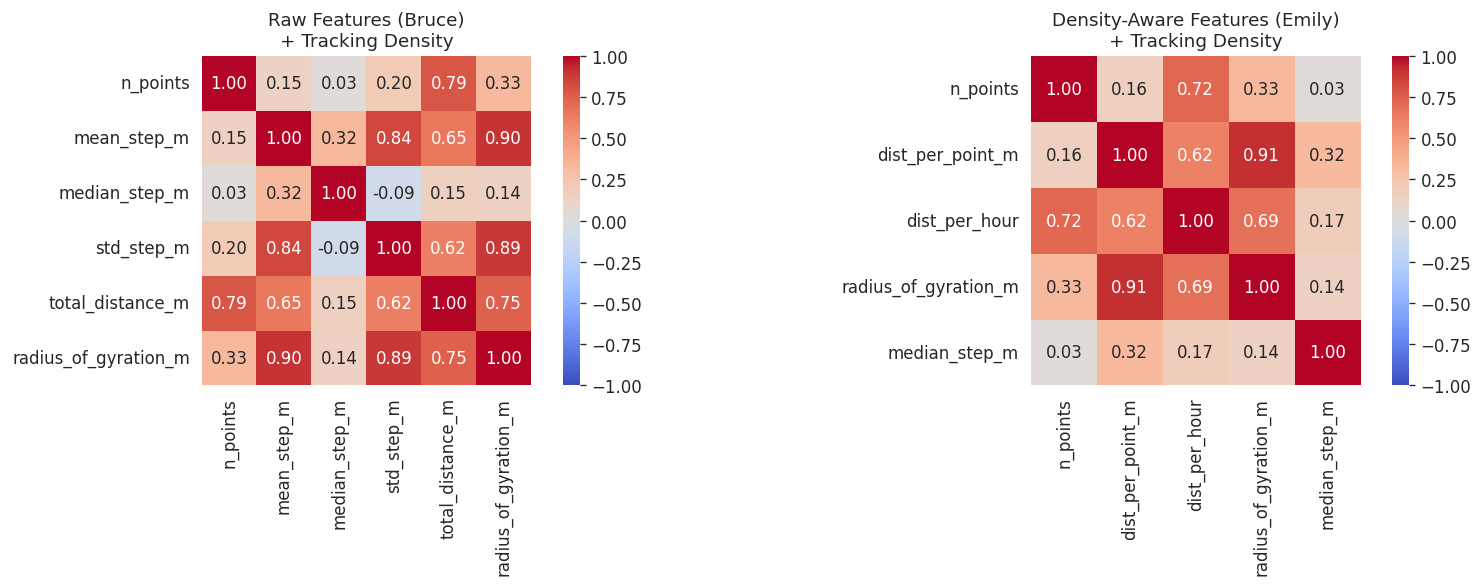

In [10]:
# Side-by-side correlation heatmaps
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

raw_corr_cols = ['n_points'] + raw_features
corr_raw = cat_features[raw_corr_cols].corr(method='spearman')
sns.heatmap(corr_raw, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            ax=axes[0], vmin=-1, vmax=1, square=True)
axes[0].set_title('Raw Features (Bruce)\n+ Tracking Density', fontsize=11)

norm_corr_cols = ['n_points'] + density_features
corr_norm = cat_features[norm_corr_cols].corr(method='spearman')
sns.heatmap(corr_norm, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            ax=axes[1], vmin=-1, vmax=1, square=True)
axes[1].set_title('Density-Aware Features (Emily)\n+ Tracking Density', fontsize=11)

plt.tight_layout()
plt.savefig('fig_density_confound_heatmaps.png', dpi=150, bbox_inches='tight')
plt.show()


- Key finding: distance-per-hour remains confounded (rho=0.73) because tracking duration and observation count are correlated. distance-per-point (rho=0.16) achieves the best density correction.

##  Integration - Indoor Access Stratification (Erica + Emily)

- Erica's M2 restricted analysis to mostly-indoor cats to control for environmental constraints

- Then apply her indoor-access framework to Emily's density-aware features and test all three access groups

**Changing:** Erica used raw features on indoor cats only. Here we use density-aware features across all access groups.

In [13]:
# Indoor access categorization (from Erica's M2)
cat_features['indoor_access'] = cat_features['hrs_indoors'].apply(
    lambda x: 'Mostly indoor' if x >= 12
    else ('Mostly outdoor' if x < 6 else 'Mixed')
    if pd.notna(x) else np.nan
)

print("Indoor access group sizes:")
print(cat_features['indoor_access'].value_counts())

Indoor access group sizes:
indoor_access
Mostly indoor     62
Mixed             31
Mostly outdoor     8
Name: count, dtype: int64


In [14]:
# Analyze each group
for group in ['Mostly indoor', 'Mixed', 'Mostly outdoor']:
    subset = cat_features[cat_features['indoor_access'] == group]
    sub_clean = subset[density_features].dropna()
    if len(sub_clean) < 5:
        print(f"\n{group} (n={len(sub_clean)}): too few cats for analysis")
        continue

    X_sub = StandardScaler().fit_transform(sub_clean)

    # K-Means k=2
    km = KMeans(n_clusters=min(2, len(sub_clean)), random_state=42, n_init=10)
    labs = km.fit_predict(X_sub)
    sil = silhouette_score(X_sub, labs) if len(set(labs)) > 1 else float('nan')

    print(f"\n{group} (n={len(sub_clean)}):  k=2 silhouette = {sil:.3f}")
    for col in density_features:
        vals = subset[col].dropna()
        print(f"  {col}: mean={vals.mean():.1f}, std={vals.std():.1f}, skew={vals.skew():.2f}")


Mostly indoor (n=62):  k=2 silhouette = 0.604
  dist_per_point_m: mean=58.0, std=39.1, skew=2.15
  dist_per_hour: mean=76.1, std=109.9, skew=4.00
  radius_of_gyration_m: mean=176.8, std=225.0, skew=2.35
  median_step_m: mean=28.3, std=9.8, skew=1.23

Mixed (n=31):  k=2 silhouette = 0.825
  dist_per_point_m: mean=69.6, std=97.3, skew=4.71
  dist_per_hour: mean=79.5, std=158.8, skew=4.63
  radius_of_gyration_m: mean=255.1, std=748.3, skew=5.37
  median_step_m: mean=29.1, std=7.2, skew=0.65

Mostly outdoor (n=8):  k=2 silhouette = 0.644
  dist_per_point_m: mean=110.3, std=196.2, skew=2.80
  dist_per_hour: mean=210.5, std=349.3, skew=2.51
  radius_of_gyration_m: mean=492.9, std=1095.6, skew=2.81
  median_step_m: mean=26.7, std=12.3, skew=-0.08


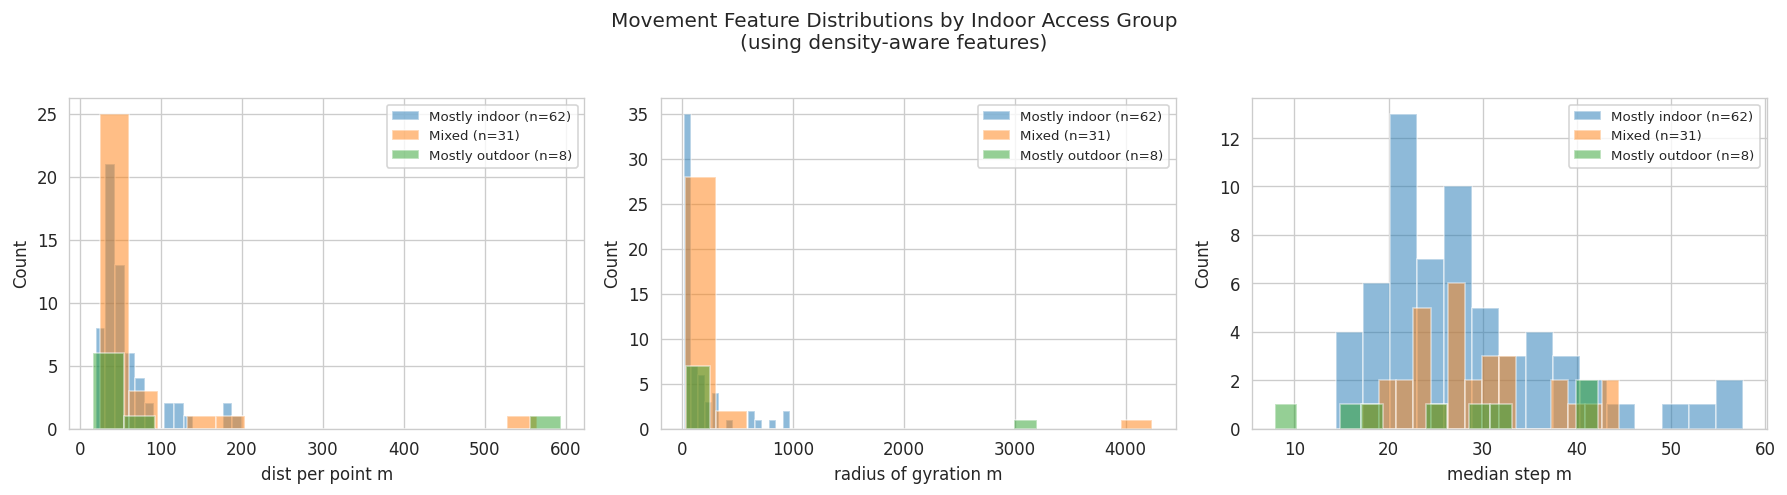

In [15]:
# Distribution plots by indoor access group
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
plot_features = ['dist_per_point_m', 'radius_of_gyration_m', 'median_step_m']

for i, feat in enumerate(plot_features):
    for group in ['Mostly indoor', 'Mixed', 'Mostly outdoor']:
        data = cat_features[cat_features['indoor_access'] == group][feat].dropna()
        if len(data) > 2:
            axes[i].hist(data, alpha=0.5, label=f"{group} (n={len(data)})", bins=15)
    axes[i].set_xlabel(feat.replace('_', ' '))
    axes[i].set_ylabel('Count')
    axes[i].legend(fontsize=8)

plt.suptitle('Movement Feature Distributions by Indoor Access Group\n(using density-aware features)',
             y=1.02)
plt.tight_layout()
plt.savefig('fig_indoor_stratification.png', dpi=150, bbox_inches='tight')
plt.show()


- All groups show right-skewed, continuous distributions. Erica's M2 continuum finding is confirmed with density-aware features.

## Integration - Unified Feature Redundancy Analysis

Multiple members noted high feature redundancy in M2. Here we examine redundancy across ALL movement features from all members in a single analysis.

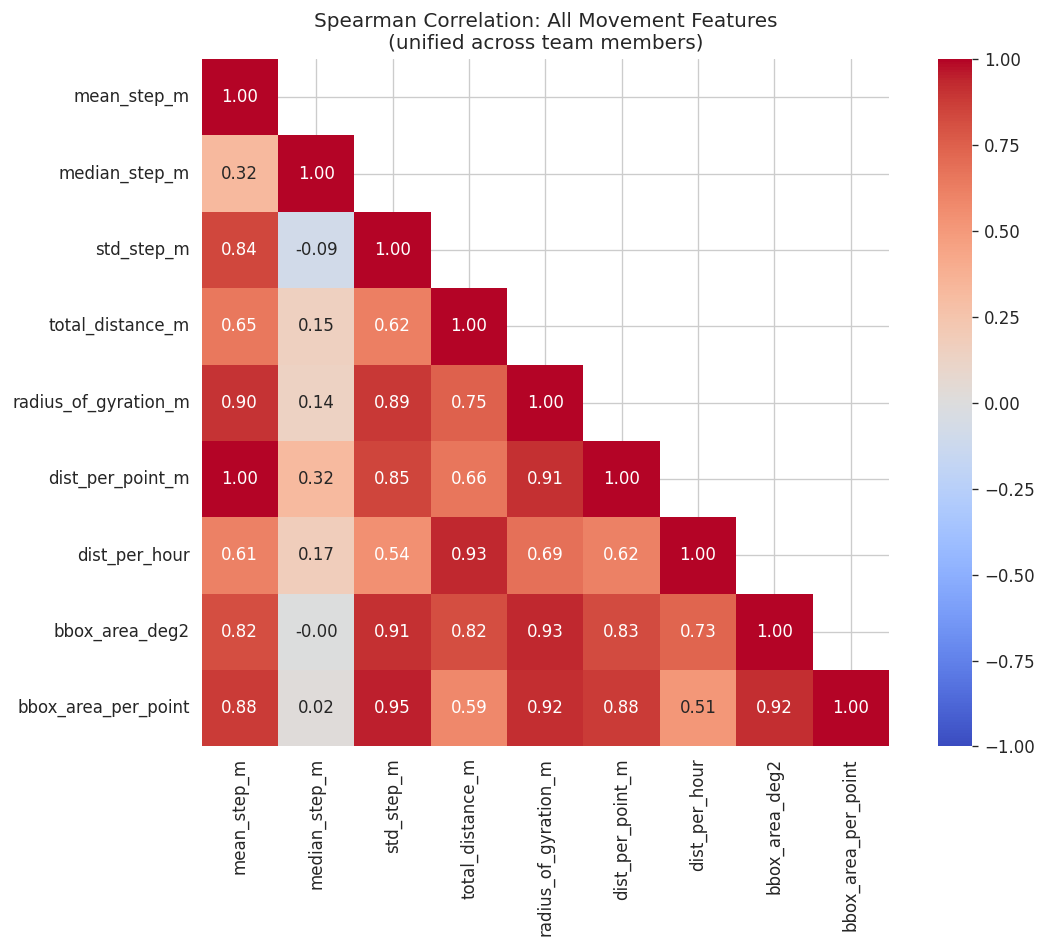

In [16]:
# Comprehensive redundancy heatmap
all_movement = [
    'mean_step_m', 'median_step_m', 'std_step_m',
    'total_distance_m', 'radius_of_gyration_m',
    'dist_per_point_m', 'dist_per_hour',
    'bbox_area_deg2', 'bbox_area_per_point'
]

corr_all = cat_features[all_movement].dropna().corr(method='spearman')

plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_all, dtype=bool), k=1)
sns.heatmap(corr_all, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            mask=mask, square=True, vmin=-1, vmax=1)
plt.title('Spearman Correlation: All Movement Features\n(unified across team members)')
plt.tight_layout()
plt.savefig('fig_redundancy_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

In [17]:
# Identify high-redundancy pairs
print("Feature pairs with |Spearman rho| > 0.80:")
print("=" * 60)
count = 0
for i in range(len(all_movement)):
    for j in range(i + 1, len(all_movement)):
        r = corr_all.iloc[i, j]
        if abs(r) > 0.80:
            print(f"  {all_movement[i]:25s} <-> {all_movement[j]:25s}  rho={r:+.3f}")
            count += 1

total_pairs = len(all_movement) * (len(all_movement) - 1) // 2
print(f"\n{count} of {total_pairs} pairs are highly redundant (|rho| > 0.80)")

Feature pairs with |Spearman rho| > 0.80:
  mean_step_m               <-> std_step_m                 rho=+0.842
  mean_step_m               <-> radius_of_gyration_m       rho=+0.903
  mean_step_m               <-> dist_per_point_m           rho=+0.999
  mean_step_m               <-> bbox_area_deg2             rho=+0.820
  mean_step_m               <-> bbox_area_per_point        rho=+0.877
  std_step_m                <-> radius_of_gyration_m       rho=+0.886
  std_step_m                <-> dist_per_point_m           rho=+0.846
  std_step_m                <-> bbox_area_deg2             rho=+0.911
  std_step_m                <-> bbox_area_per_point        rho=+0.949
  total_distance_m          <-> dist_per_hour              rho=+0.935
  total_distance_m          <-> bbox_area_deg2             rho=+0.820
  radius_of_gyration_m      <-> dist_per_point_m           rho=+0.908
  radius_of_gyration_m      <-> bbox_area_deg2             rho=+0.931
  radius_of_gyration_m      <-> bbox_area_per_po

- Only median_step_m is consistently non-redundant with other features.

- Effective dimensionality is ~2 (spatial scale + per-step behavior).